In [1]:
#Importing Packages

#Data
import pandas as pd
import numpy as np

#ML Frameworks
#scikit learn - library for predictions
#statsmodels - library for models
import sklearn as sk
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import  linear_model
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels as sm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

#Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt


## Understanding Key Drivers of Price

Real estate prices can be seperated effectively in to two distinct categories; **county and metro**. As the location itself acts as a key distinction between the average type, size and price of the property. 

To better understand the market demand, we want to examine the metrics that indicate the prices at which properties are being listed/sold in each particular region. 

The metrics that we want to look at are:
>
 * 'property_type_id': id number indicating which type of property (i.e All Residences, Single Family Homes, Townhouses etc.)
 * 'year': year the observation
 * 'period_begin': start date
 * 'period_end': end date
 * 'period_duration': duration of the data record
 * 'median_sale_price': median sale price of homes sold
 * 'adjusted_median_sale_price': median sale price of homes sold adjusted based on inflation
 * 'median_list_price': median list price of homes
 * 'adjusted_median_list_price': median list price of homes sold adjusted based on inflation
 * 'avg_sale_to_list': ratio comparing the sale price and list price
 * 'median_sale_ppsf': median price per square foot of homes sold
 * 'adjusted_median_sale_ppsf': median price per square foot of homes sold adjusted by inflation
 * 'last_updated' : retreiving the latest updated data
 * 'average annual inflation' : an important factor when the comes to the valuation of USD when purchasing property.



In [2]:
#Data Wrangling from Redfin
url2 = 'https://raw.githubusercontent.com/ayiply/test_repo/main/us_national_market_tracker.tsv000'
national_df = pd.read_csv(url2, sep = "\t")


In [3]:
national_df.head()

,period_begin,period_end,period_duration,region_type,region_type_id,table_id,is_seasonally_adjusted,region,city,state,...,sold_above_list_yoy,price_drops,price_drops_mom,price_drops_yoy,off_market_in_two_weeks,off_market_in_two_weeks_mom,off_market_in_two_weeks_yoy,parent_metro_region,parent_metro_region_metro_code,last_updated
0,2018-10-01,2018-10-31,30,national,11,1400,f,National,National,U.S.,...,-0.010469,0.182812,0.015493,0.042999,0.316318,-0.024323,-0.032624,NaN,NaN,2022-04-10 14:49:10
1,2020-10-01,2020-10-31,30,national,11,1400,f,National,National,U.S.,...,0.054528,0.134954,0.005643,-0.013543,0.358236,-0.015613,0.038912,NaN,NaN,2022-04-10 14:49:10
2,2020-01-01,2020-01-31,30,national,11,1400,f,National,National,U.S.,...,-0.002394,0.108246,0.027181,-0.012040,0.381831,0.139909,0.009160,NaN,NaN,2022-04-10 14:49:10
3,2012-06-01,2012-06-30,30,national,11,1400,f,National,National,U.S.,...,0.035716,0.059756,0.000872,-0.021419,0.292725,-0.015050,0.062571,NaN,NaN,2022-04-10 14:49:10
4,2017-03-01,2017-03-31,30,national,11,1400,f,National,National,U.S.,...,0.013701,0.108722,0.007264,-0.004099,0.466676,0.003419,0.022455,NaN,NaN,2022-04-10 14:49:10


In [4]:
national_df.columns

Index(['period_begin', 'period_end', 'period_duration', 'region_type',
       'region_type_id', 'table_id', 'is_seasonally_adjusted', 'region',
       'city', 'state', 'state_code', 'property_type', 'property_type_id',
       'median_sale_price', 'median_sale_price_mom', 'median_sale_price_yoy',
       'median_list_price', 'median_list_price_mom', 'median_list_price_yoy',
       'median_ppsf', 'median_ppsf_mom', 'median_ppsf_yoy', 'median_list_ppsf',
       'median_list_ppsf_mom', 'median_list_ppsf_yoy', 'homes_sold',
       'homes_sold_mom', 'homes_sold_yoy', 'pending_sales',
       'pending_sales_mom', 'pending_sales_yoy', 'new_listings',
       'new_listings_mom', 'new_listings_yoy', 'inventory', 'inventory_mom',
       'inventory_yoy', 'months_of_supply', 'months_of_supply_mom',
       'months_of_supply_yoy', 'median_dom', 'median_dom_mom',
       'median_dom_yoy', 'avg_sale_to_list', 'avg_sale_to_list_mom',
       'avg_sale_to_list_yoy', 'sold_above_list', 'sold_above_list_mom',
 

### Introduce year column to each observation

In [5]:
def year(str):
    return int(str[:4])

national_df = national_df.assign(year = national_df['period_begin'].apply(year))

### Filter necessary informaton

In [6]:
national_df = national_df[['property_type_id','period_begin', 'period_end', 'year', 'period_duration' ,'median_list_price','median_sale_price', 'median_list_ppsf', 'avg_sale_to_list', 'last_updated']]

In [7]:
national_df['last_updated'].value_counts().index.tolist()[-1]

'2022-04-11 00:00:00'

In [8]:
national_df['last_updated'].value_counts()

2022-04-10 14:49:10    738
2022-04-11 00:00:00    615
Name: last_updated, dtype: int64

In [9]:
# property_type_id == -1; All residential homes
national_df = national_df.loc[national_df['property_type_id'] == -1]

#Removing Duplicate Entries, Leaving Latest Update
national_df = national_df.loc[national_df['last_updated'] == '2022-04-10 14:49:10']
#national_df = national_df.loc[national_df['last_updated'] == national_df['last_updated'].value_counts().index.tolist()[-1]]

#Sorting by ascending order of entry period end date
national_df.sort_values('period_end', inplace = True)

national_df.head()


,property_type_id,period_begin,period_end,year,period_duration,median_list_price,median_sale_price,median_list_ppsf,avg_sale_to_list,last_updated
1028,-1,2012-01-01,2012-01-31,2012,30,182741.0,158955.0,102.0,0.956285,2022-04-10 14:49:10
1016,-1,2012-02-01,2012-02-29,2012,30,192252.0,159915.0,105.0,0.958041,2022-04-10 14:49:10
337,-1,2012-03-01,2012-03-31,2012,30,198860.0,170681.0,108.0,0.961785,2022-04-10 14:49:10
1080,-1,2012-04-01,2012-04-30,2012,30,198927.0,177774.0,107.0,0.965150,2022-04-10 14:49:10
539,-1,2012-05-01,2012-05-31,2012,30,200718.0,186050.0,108.0,0.968565,2022-04-10 14:49:10


### Introduce inflation-by-year Column and base_inflation column

In [10]:
#Inflation Data
url3 = 'https://raw.githubusercontent.com/ayiply/test_repo/main/inflation_data.csv'
inflation_df = pd.read_csv(url3)

inflation_df.columns
inflation_df = inflation_df.rename({'inflation rate' : 'inf_rate'}, axis = 'columns' )

inf_dict = dict(zip(inflation_df.year, inflation_df.inf_rate))

inflation_df
base_inflation = inflation_df[inflation_df['year'] > 2011]['amount'].tolist()
base_inflation = [i/base_inflation[0] for i in base_inflation]
base_inflation
year_list = list(range(2012, 2023, 1))
year_list

def total_inflation(year):
    for i in range(12):
        if year == year_list[i]:
            return round(base_inflation[i], 2)
            
national_df = national_df.assign(base_inflation = national_df['year'].apply(total_inflation))

In [11]:
#List for inflation rates by year in period_begin
inflation_column = []

#converting period_begins column into iterable list
ser = pd.DataFrame(national_df, columns = ['period_begin'])
dates = ser.squeeze()
date_list = dates.to_list()

#assigning annual inflation rate based on year found in list of dates' strings
for key in inf_dict:
  for entry in date_list:
    if str(key) in entry:
      inflation_column.append(inf_dict[key])
  
#appending column to national_df
national_df['inflation_by_year'] = inflation_column

national_df.head()

,property_type_id,period_begin,period_end,year,period_duration,median_list_price,median_sale_price,median_list_ppsf,avg_sale_to_list,last_updated,base_inflation,inflation_by_year
1028,-1,2012-01-01,2012-01-31,2012,30,182741.0,158955.0,102.0,0.956285,2022-04-10 14:49:10,1.0,0.02
1016,-1,2012-02-01,2012-02-29,2012,30,192252.0,159915.0,105.0,0.958041,2022-04-10 14:49:10,1.0,0.02
337,-1,2012-03-01,2012-03-31,2012,30,198860.0,170681.0,108.0,0.961785,2022-04-10 14:49:10,1.0,0.02
1080,-1,2012-04-01,2012-04-30,2012,30,198927.0,177774.0,107.0,0.965150,2022-04-10 14:49:10,1.0,0.02
539,-1,2012-05-01,2012-05-31,2012,30,200718.0,186050.0,108.0,0.968565,2022-04-10 14:49:10,1.0,0.02


### Calculate Adjusted Price

In [12]:
national_df = national_df.assign(adjusted_median_list_price = national_df['median_list_price'] / national_df['base_inflation'])
national_df = national_df.assign(adjusted_median_sale_price = national_df['median_sale_price'] / national_df['base_inflation'])
national_df = national_df.assign(adjusted_median_list_ppsf = national_df['median_list_ppsf'] / national_df['base_inflation'])
#national_df = national_df[['property_type_id', 'year', 'median_list_price', 'adjusted_median_list_price', 'median_sale_price', 'adjusted_median_sale_price', 'median_list_ppsf', 'adjusted_median_list_ppsf', 'base_inflation', 'inflation_by_year']]
national_df.head()

,property_type_id,period_begin,period_end,year,period_duration,median_list_price,median_sale_price,median_list_ppsf,avg_sale_to_list,last_updated,base_inflation,inflation_by_year,adjusted_median_list_price,adjusted_median_sale_price,adjusted_median_list_ppsf
1028,-1,2012-01-01,2012-01-31,2012,30,182741.0,158955.0,102.0,0.956285,2022-04-10 14:49:10,1.0,0.02,182741.0,158955.0,102.0
1016,-1,2012-02-01,2012-02-29,2012,30,192252.0,159915.0,105.0,0.958041,2022-04-10 14:49:10,1.0,0.02,192252.0,159915.0,105.0
337,-1,2012-03-01,2012-03-31,2012,30,198860.0,170681.0,108.0,0.961785,2022-04-10 14:49:10,1.0,0.02,198860.0,170681.0,108.0
1080,-1,2012-04-01,2012-04-30,2012,30,198927.0,177774.0,107.0,0.965150,2022-04-10 14:49:10,1.0,0.02,198927.0,177774.0,107.0
539,-1,2012-05-01,2012-05-31,2012,30,200718.0,186050.0,108.0,0.968565,2022-04-10 14:49:10,1.0,0.02,200718.0,186050.0,108.0


### Get aggregating statistics of national_df

In [13]:
national_df.describe()

,property_type_id,year,period_duration,median_list_price,median_sale_price,median_list_ppsf,avg_sale_to_list,base_inflation,inflation_by_year,adjusted_median_list_price,adjusted_median_sale_price,adjusted_median_list_ppsf
count,123.0,123.000000,123.0,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000
mean,-1.0,2016.634146,30.0,274995.276423,263139.382114,148.008130,0.982481,1.074634,0.019268,253874.720829,242785.380332,136.610343
std,0.0,2.973292,0.0,56606.828048,57705.244118,30.850113,0.013286,0.061621,0.014775,37836.517779,39459.467084,20.376654
min,-1.0,2012.000000,30.0,178575.000000,158955.000000,100.000000,0.956285,1.000000,0.000000,178575.000000,158955.000000,100.000000
25%,-1.0,2014.000000,30.0,230748.000000,219016.500000,125.000000,0.974285,1.030000,0.010000,224510.679612,213930.976641,121.359223
50%,-1.0,2017.000000,30.0,271115.000000,256584.000000,144.000000,0.980225,1.070000,0.020000,255039.047619,242965.714286,135.514019
75%,-1.0,2019.000000,30.0,307471.000000,293014.000000,162.500000,0.986417,1.110000,0.020000,278535.885362,263937.837838,146.874751
max,-1.0,2022.000000,30.0,426625.000000,412687.000000,233.000000,1.025384,1.260000,0.070000,338591.269841,327529.365079,184.920635


# **Notes for the team:** 
So the national_df DataFrame contains aggregate values for all residential homes across the US. Potentially if we wanted to look at specific states (like California, Washington, etc) there are more data for location specific metrics which we can further investigate. 

### Median List to Sale Price
We plotted the median list price against the median sale price to see if there was a correlation between the two. Based off the plot, we found that typically the final sale price is lower than the initial list price. To see if inflation had any effect, we adjusted the list and sale prices for inflation and plotted them on the same graph. We found that the trend stayed the same even after the adjustment.

[Text(0.5, 0, 'List Price'), Text(0, 0.5, 'Sale Price')]

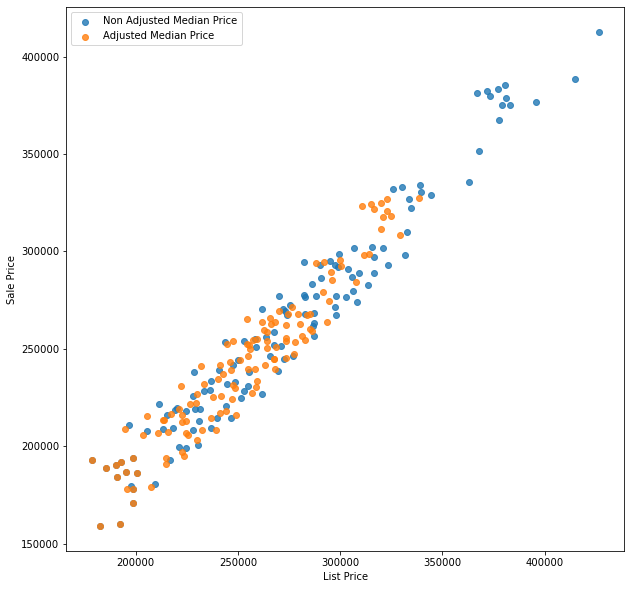

In [20]:
fig_price_diff, ax_price_diff = plt.subplots(figsize=(10,10))
sns.regplot(x = "median_list_price", y = "median_sale_price", data = national_df, fit_reg=False)
sns.regplot(x = "adjusted_median_list_price", y = "adjusted_median_sale_price", data = national_df, fit_reg=False)

ax_price_diff.legend(labels = ["Non Adjusted Median Price","Adjusted Median Price"])
ax_price_diff.set(xlabel = "List Price", ylabel = "Sale Price")

### Median List Price Per Square Foot (PPSF)
In this figure, we plotted the median list price per square foot over time. Unsurprisingly, the prices increased as time progressed, but it is worth noting that the largest increases per year are from 2020 to 2022. This is likely do to the effects of the world wide pandemic. In addition, we plotted the same values adjusted for inflation and found that the trend was largely similar. However, one notable difference is that some of the adjusted values in 2020, namely the highest three values are now more expensive then the lowest value in 2021. When in the non adjusted plot, the lowest value in 2021, is greater than the highest value in 2020. This may be do to how we calculated for inflation. More investigation is needed to see if it is a trend in the data or a mistake with how we adjusted for inflation.

[Text(0.5, 0, 'Year'), Text(0, 0.5, 'Median List PPSF')]

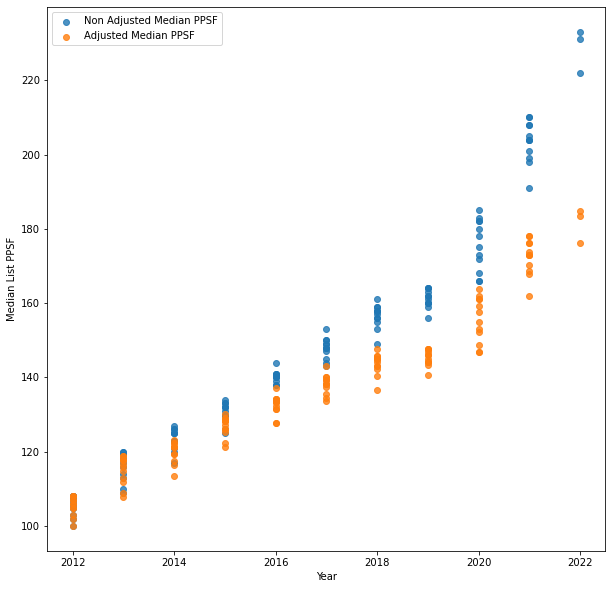

In [21]:
fig_ppsf, ax_ppsf = plt.subplots(figsize=(10,10))
sns.regplot(x = "year", y = "median_list_ppsf", data = national_df, fit_reg=False)
sns.regplot(x = "year", y = "adjusted_median_list_ppsf", data = national_df, fit_reg=False)

ax_ppsf.legend(labels = ["Non Adjusted Median PPSF","Adjusted Median PPSF"])
ax_ppsf.set(xlabel = "Year", ylabel = "Median List PPSF")

### Non Adjusted Prices Polynomial Regression
We trained a polynomial regression model on the list and sale prices to predict final sale prices based on the initial list price. We started with determining the number of degrees that would have the best accuracy. To measure the accuracy, we used r-squared. The degrees we tested were: 1, 2, 3, 6, 10, and 20. Looking at the figure and r-squared results, it appears that degrees 3 and 6 have the highest r-squared value of 0.95. This tells us that these would be a good number of features to include to have the most accurate algorithm. Given that there are two possibilities between 3 and 6 degrees, we will later determine if either value leads to a better r-squared value.

R-squared values: 

Polynomial degree 1: R-squared Score = 0.948
Polynomial degree 2: R-squared Score = 0.949
Polynomial degree 3: R-squared Score = 0.95
Polynomial degree 6: R-squared Score = 0.95
Polynomial degree 10: R-squared Score = 0.937
Polynomial degree 20: R-squared Score = 0.762


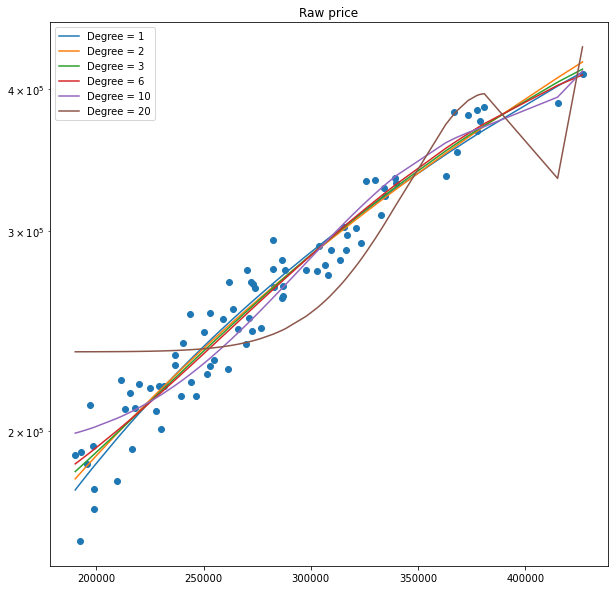

In [16]:
X = national_df['median_list_price']
y = national_df['median_sale_price']

X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size=0.33, random_state=42)
     

sorted_index = np.argsort(X_train)
X_train = X_train.to_numpy()[sorted_index]
y_train = y_train.to_numpy()[sorted_index]

sorted_index = np.argsort(X_test)
X_test = X_test.to_numpy()[sorted_index]
y_test = y_test.to_numpy()[sorted_index]

degrees = [1, 2, 3, 6, 10, 20]

y_pred = np.zeros((len(X_train), len(degrees)))

for i, degree in enumerate(degrees):
    
    # make pipeline: create features, then feed them to linear_reg model
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model.fit(np.array(X_train).reshape(-1,1), y_train)
    
    # predict on test and train data
    # store the predictions of each degree in the corresponding column
    y_pred[:, i] = model.predict(np.array(X_train).reshape(-1,1))
    
plt.figure(figsize=(10, 10))

plt.scatter(X_train, y_train)
plt.yscale('log')
plt.title("Raw price")
for i, degree in enumerate(degrees):    
    plt.plot(X_train, y_pred[:, i], label=f'Degree = {str(degree)}')
    plt.legend(loc='upper left')
    
print("R-squared values: \n")
for i, degree in enumerate(degrees):
    train_r2 = round(sk.metrics.r2_score(y_train, y_pred[:, i]), 3)
    print("Polynomial degree {0}: R-squared Score = {1}".format(degree, train_r2)) 
                    

### Adjusted List to Sale Prices Polynomial Regression
Similar to the non adjusted list to sale price polynomial regression, we performed the same process, but with the values adjusted for inflation. We found that the r-squared value ended up being lower than the non adjusted sale and list price values. Currently, we are not entirely certain as to why this is the case. Not only are the r-squared values lower, the difference between the different number of features is also much smaller as well.

R-squared values: 

Polynomial degree 1: R-squared Score = 0.902
Polynomial degree 2: R-squared Score = 0.907
Polynomial degree 3: R-squared Score = 0.907
Polynomial degree 6: R-squared Score = 0.906
Polynomial degree 10: R-squared Score = 0.901
Polynomial degree 20: R-squared Score = 0.837


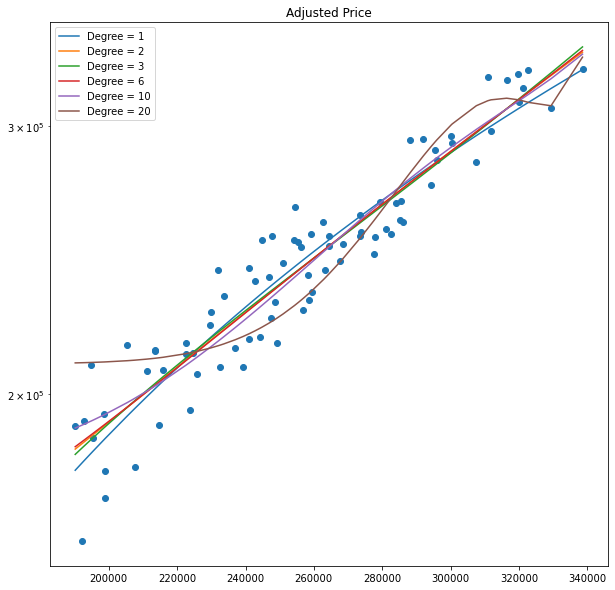

In [17]:
X = national_df['adjusted_median_list_price']
y = national_df['adjusted_median_sale_price']

X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size=0.33, random_state=42)
     

sorted_index = np.argsort(X_train)
X_train = X_train.to_numpy()[sorted_index]
y_train = y_train.to_numpy()[sorted_index]

sorted_index = np.argsort(X_test)
X_test = X_test.to_numpy()[sorted_index]
y_test = y_test.to_numpy()[sorted_index]

degrees = [1, 2, 3, 6, 10, 20]

y_pred = np.zeros((len(X_train), len(degrees)))

for i, degree in enumerate(degrees):
    
    # make pipeline: create features, then feed them to linear_reg model
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model.fit(np.array(X_train).reshape(-1,1), y_train)
    
    # predict on test and train data
    # store the predictions of each degree in the corresponding column
    y_pred[:, i] = model.predict(np.array(X_train).reshape(-1,1))
    
plt.figure(figsize=(10, 10))

plt.scatter(X_train, y_train)
plt.yscale('log')
plt.title("Adjusted Price")
for i, degree in enumerate(degrees):    
    plt.plot(X_train, y_pred[:, i], label=f'Degree = {str(degree)}')
    plt.legend(loc='upper left')
    
print("R-squared values: \n")
for i, degree in enumerate(degrees):
    train_r2 = round(sk.metrics.r2_score(y_train, y_pred[:, i]), 3)
    print("Polynomial degree {0}: R-squared Score = {1}".format(degree, train_r2)) 
                                  

### Non Adjusted Prices KFolds Linear Regression
Since we are currently only working with 123 data points, we decided to use KFolds in order to maximize the amount of information we can gain from our limited data. In the following cell block, we have the non adjusted list and sale prices as our data. Once again, we perform linear regression, but this time using KFolds. The mean r-squared for this model is lower than the polynomial regression.

In [18]:
X = national_df['median_list_price']
y = national_df['median_sale_price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

model = LinearRegression()
folds = KFold(n_splits = 5, shuffle = True, random_state = 42)
r2 = cross_val_score(model, np.array(X_train).reshape(-1,1), y_train, scoring='r2', cv=folds)
mse = cross_val_score(model, np.array(X_train).reshape(-1,1), y_train, scoring='neg_mean_squared_error', cv=5)
print("R-squared value for raw price with 5-fold validation is: " + str(round(np.mean(r2), 2)))
print("MSE value for raw price with 5-fold validation is: " + str(round(np.mean(mse), 2)))

R-squared value for raw price with 5-fold validation is: 0.93
MSE value for raw price with 5-fold validation is: -178780326.8


### Adjusted List to Sale Prices KFolds Linear Regression
Similar to how we used the inflation adjusted values in our other plots and models, we did the same for the KFolds linear regression. Like the results found in our polynomial regressions, the r-squared value in this model is also lower than the model that used the non adjusted values.

In [19]:
X = national_df['adjusted_median_list_price']
y = national_df['adjusted_median_sale_price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
     
model = LinearRegression()
folds = KFold(n_splits = 5, shuffle = True, random_state = 42)
r2 = cross_val_score(model, np.array(X_train).reshape(-1,1), y_train, scoring='r2', cv=folds)
mse = cross_val_score(model, np.array(X_train).reshape(-1,1), y_train, scoring='neg_mean_squared_error', cv=5)
print("R-squared value for raw price with 5-fold validation is: " + str(round(np.mean(r2), 2)))
print("MSE value for raw price with 5-fold validation is: " + str(round(np.mean(mse), 2)))

R-squared value for raw price with 5-fold validation is: 0.88
MSE value for raw price with 5-fold validation is: -155762121.47


### Future Plans
* Going forward, we want to investigate the discrepancies found when using the inflation adjusted data compared to the non adjusted data.
* More metrics for determining performance of a model
* Currently, we are using the aggregate data at a national level, which is partly why there are only 123 rows. Later we want to use more granular data perhaps at a state level or even metro level. This will provide more data points along with different features that we will be able to use to better train our model.